In [1]:
%load_ext autoreload
%matplotlib inline

/Users/diego/.pyenv/versions/miniconda-latest/lib/python2.7/site-packages/subprocess32.py:472: RuntimeWarning: The _posixsubprocess module is not being used. Child process reliability may suffer if your program uses threads.
  "program uses threads.", RuntimeWarning)


In [2]:
%autoreload 2

import torch
from torch.autograd import Variable
from torch import nn, optim
import torchvision.models
import numpy as np
import models, utils
from IPython import display

## Introduction

In order to transfer the style from one image to another one there are several different things that we need have clear:

1. __Content Image__: This is the 'real world' image that we want to be modified.
2. __Style Image__: This is the 'painting´s' image that we want to take the style from.


For this task, the model we'll be using is the trained version of the __VGG network__. VGG is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”.

- The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes.

### 1. Load trained VGG Model

In [3]:
net = models.ModifiedVGG()

### 2. Load Content Image

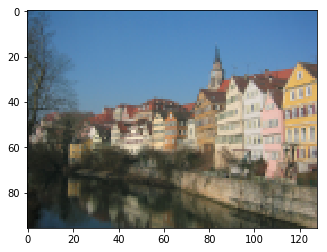

torch.Size([1, 3, 96, 128])

In [4]:
content_filename = 'tubingen.jpg'
content_tensor = utils.load_image(content_filename, max_size=(128,128))
# Pre-process tensor
pre_content_tensor = utils.preprocess(content_tensor)
# Convert to variable
content_var = utils.tensor_to_4d_var(pre_content_tensor, requires_grad=False)
# Print size
content_var.size()

### 3. Load Style Image

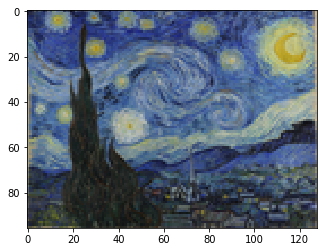

torch.Size([1, 3, 96, 128])

In [5]:
style_filename = 'starry-night.jpg'
style_tensor = utils.load_image(style_filename, shape=reversed(content_var.size()[2:]))
# Pre-process tensor
pre_style_tensor = utils.preprocess(style_tensor)
# Convert to variable
style_var = utils.tensor_to_4d_var(style_tensor, requires_grad=False)
# Print size
style_var.size()

In [6]:
style_layer_names = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
content_layer_names = ['conv4_2']

### Convert Style and Content images to Gram Matrix Representations

In [7]:
def representation(image_var, net, layer_names, gram):
    '''
    Return list with gram matrix representations of the input 'image' as a PyTorch Variable
    '''
    # Obtain conv. layers output
    layers = net(image_var)
    # Filter layers
    out = [layers[name] for name in layer_names]
    if gram:
        # Generate Gram matrices
        out = utils.gram_matrices(out)
    return out

In [8]:
content_repr = representation(content_var, net, content_layer_names, gram=False)
style_repr = representation(style_var, net, style_layer_names, gram=True)

# content_repr = representation(content_var - utils.imagenet_mean(content_var), net, content_layer_names, gram=False)
# style_repr = representation(style_var - utils.imagenet_mean(style_var), net, style_layer_names, gram=True)

### Create input Image

In [9]:
input_tensor = content_tensor.clone()
pre_input_tensor = utils.preprocess(input_tensor)
#torch.randn(content_tensor.size()).float()#content_tensor.clone()
input_var = utils.tensor_to_4d_var(pre_input_tensor, requires_grad=True)

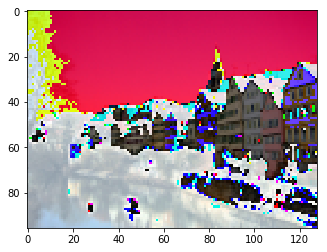

In [10]:
utils.display_image(input_var.data)

### Calculate Loss

In [ ]:
def total_loss(target_content, target_style, input_content, input_style, content_weight=8, style_weight=10000):
    criterion = nn.MSELoss()
    cl = utils.content_loss(criterion, target_content, input_content)
    sl = utils.style_loss(criterion, target_style, input_style)
    return (content_weight * cl) + (style_weight * sl), cl, sl

### Train model

0
Total Loss: 0.000591423828155
Content Loss: 0.0
Style Loss: 5.91423834351e-08


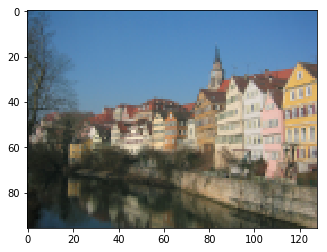

25
Total Loss: 0.00645697489381
Content Loss: 0.000745401717722
Style Loss: 4.93761049825e-08


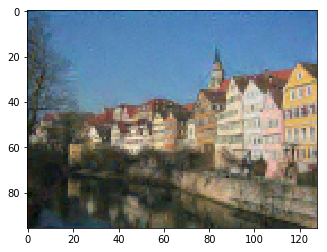

50
Total Loss: 0.00148879527114
Content Loss: 0.000121917117212
Style Loss: 5.13458253693e-08


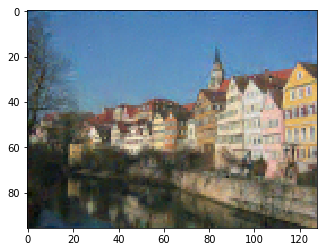

In [ ]:
epochs = 1000

# Load Optimizer
# optimizer = optim.LBFGS([input_var])
optimizer = optim.Adam([input_var], lr=0.01)

for t in range(epochs):
    def closure():
        # Correct the values of updated input image
        utils.clip_preprocessed(input_var, 0, 1)
        # Obtain Gram Matrix of Input Image
        input_content = representation(input_var, net, content_layer_names, gram=False)
        input_style = representation(input_var, net, style_layer_names, gram=True)
        # Reset gradients
        optimizer.zero_grad()
        # Calculate loss
        loss, c_loss, s_loss = total_loss(content_repr, style_repr, input_content, input_style)
        loss.backward()
        
        if t % 25 ==0:
            print(t)
            print('Total Loss: {}'.format(loss.data[0]))
            print('Content Loss: {}'.format(c_loss.data[0]))
            print('Style Loss: {}'.format(s_loss.data[0]))
            input_copy = input_var.clone()
            utils.postprocess(input_copy, 0, 1)
            utils.display_image(input_copy.data)
#             utils.display_image((input_var+utils.imagenet_mean(style_var)) .data)
        return loss
    
    optimizer.step(closure)
#     display.clear_output(wait=True)